## ADAM vs SGD

This is a response to Siraj Raval's [Coding Challenge](https://github.com/llSourcell/The_evolution_of_gradient_descent/) to implement the Adam Optimization Strategy. In this notebook, we are building a 3-layer neural network with numpy for the [Kaggle Titanic Dataset](https://www.kaggle.com/c/titanic/data), and comparing the performance difference between a standard Stochastic Gradient Descent and Adam.

With reference to:
1. [Adam: A method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) by Diederik P. Kingma, Jimmy Ba  
2. [CS231: Neural Networks](http://cs231n.github.io/neural-networks-3/#update) by Andrej Karpathy
3. [Optimizing Gradient Descent](http://sebastianruder.com/optimizing-gradient-descent/index.html#adam) by Sebastian Ruder

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preparation

In [2]:
train = pd.read_csv('Titanic.csv')

# Converting Passenger Class and Embarked Location to binary variables
dummy_fields = ['Sex', 'Pclass', 'Embarked']
for i in dummy_fields:
    dummies = pd.get_dummies(train[i], prefix=i, drop_first=False)
    train = pd.concat([train, dummies], axis=1)

# Dropping unneeded columns 
fields_to_drop = ['PassengerId', 'Ticket', 'Name', 'Cabin', 'Fare', 'Pclass', 'Embarked', 'Sex']
data = train.drop(fields_to_drop, axis=1)

In [3]:
# Normalising Age
mean, std = data['Age'].mean(), data['Age'].std()
data.loc[:, 'Age'] = (data['Age'] - mean)/std

data = data.fillna(0) # Replace NaN age with mean (0)

In [4]:
# Shuffle Data 
data = data.sample(frac=1).reset_index(drop=True)

# Splitting Data into Train Val and Test Set
features, targets = data.drop('Survived', axis=1), data['Survived'] 
targets = targets.values.reshape(-1, 1) # reshaping to numpy n x 1 matrix

test_X, test_y = features[-120:], targets[-120:]
val_X, val_y = features[-200:-120], targets[-200:-120]
train_X, train_y = features[:-200], targets[:-200]

## Neural Network

In [5]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = learning_rate
        self.l2_m = 0
        self.l1_m = 0
        self.l2_v = 0
        self.l1_v = 0
        self.t = 0
        
        # Weights Initilization
        self.w0 = np.random.normal(0.0, 0.1, (self.input_nodes, self.hidden_nodes))
        self.w1 = np.random.normal(0.0, 0.1, (self.hidden_nodes, self.output_nodes))
        
        def sigmoid(x, deriv=False):
            
            if deriv:
                return x*(1-x)
            return 1/(1+np.exp(-x))
        
        self.activation_function = sigmoid
        
    def train(self, features, targets, optimizer, decay_rate_1 = None, 
              decay_rate_2 = None, epsilon = None):
        # Feed Forward
        l0 = features
        l1 = self.activation_function(np.dot(l0, self.w0))
        l2 = self.activation_function(np.dot(l1, self.w1))
        
        # Backpropagation
        l2_error = l2 - targets
        l2_delta = l2_error * self.activation_function(l2, deriv=True)
        l1_error = l2_delta.dot(self.w1.T)
        l1_delta = l1_error * self.activation_function(l1, deriv=True)
        
        if optimizer == 'sgd':
            # Update Weights
            self.w1 -= self.lr * l1.T.dot(l2_delta)
            self.w0 -= self.lr * l0.T.dot(l1_delta)
            
        if optimizer == 'adam':
            # Gradients for each layer
            g1 = l1.T.dot(l2_delta)
            g0 = l0.T.dot(l1_delta)
            
            self.t += 1 # Increment Time Step
            
            # Computing 1st and 2nd moment for each layer
            self.l2_m = self.l2_m * decay_rate_1 + (1- decay_rate_1) * g1
            self.l1_m = self.l1_m * decay_rate_1 + (1- decay_rate_1) * g0
            
            self.l2_v = self.l2_v * decay_rate_2 + (1- decay_rate_2) * (g1 ** 2)
            self.l1_v = self.l1_v * decay_rate_2 + (1- decay_rate_2) * (g0 ** 2)
            
            l2_m_corrected = self.l2_m / (1-(decay_rate_1 ** self.t))
            l2_v_corrected = self.l2_v / (1-(decay_rate_2 ** self.t))
            
            # Computing bias-corrected moment
            l1_m_corrected = self.l1_m / (1-(decay_rate_1 ** self.t))
            l1_v_corrected = self.l1_v / (1-(decay_rate_2 ** self.t))
            
            # Update Weights
            w1_update = l2_m_corrected / (np.sqrt(l2_v_corrected) + epsilon)
            w0_update = l1_m_corrected / (np.sqrt(l1_v_corrected) + epsilon)
            
            self.w1 -= (self.lr * w1_update)
            self.w0 -= (self.lr * w0_update)
            
    def run(self, features):
        l0 = features
        l1 = self.activation_function(np.dot(l0, self.w0))
        l2 = self.activation_function(np.dot(l1, self.w1))
        
        return l2


In [6]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training

In [7]:
import time

def build_network(network, epochs, optimizer, batch_size = None):
    losses = {'train':[], 'validation':[]} # For Plotting of MSE

    start = time.time()
        
    # Iterating Over Epochs
    for i in range(epochs):
        
        if optimizer == 'sgd':
            # Iterating over mini batches
            for k in range(train_X.shape[0]// batch_size):
                batch = np.random.choice(train_X.index, size=batch_size)
                X, y = train_X.ix[batch].values, train_y[batch]

                network.train(X, y, optimizer)

                train_loss = MSE(network.run(train_X), train_y)
                val_loss = MSE(network.run(val_X), val_y)

            if i % 100 == 0:
                print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))
                
        if optimizer == 'adam':
            network.train(train_X, 
                          train_y, 
                          optimizer,
                          decay_rate_1 = 0.9,
                          decay_rate_2 = 0.99,
                          epsilon = 10e-8)

            train_loss = MSE(network.run(train_X), train_y)
            val_loss = MSE(network.run(val_X), val_y)

            if i % 100 == 0:
                print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))

        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
    print('Time Taken:{0:.4f}s'.format(time.time()-start))
    return losses

In [8]:
epochs = 601
learning_rate = 0.01
hidden_nodes = 6
output_nodes = 1
batch_size = 64

network_adam = NeuralNetwork(train_X.shape[1], hidden_nodes, output_nodes, learning_rate)
network_sgd = NeuralNetwork(train_X.shape[1], hidden_nodes, output_nodes, learning_rate)

print('Training Model with Adam')
losses_adam = build_network(network_adam, epochs, 'adam')

print('\nTraining Model with SGD')
losses_sgd = build_network(network_sgd, epochs, 'sgd', batch_size)

Training Model with Adam
Epoch 0, Train Loss: 0.2532487293267518, Val Loss: 0.2537055626248329
Epoch 100, Train Loss: 0.16200606136858914, Val Loss: 0.14531091584816908
Epoch 200, Train Loss: 0.1414654059787429, Val Loss: 0.1164243887762324
Epoch 300, Train Loss: 0.13545428363086362, Val Loss: 0.10774464708173859
Epoch 400, Train Loss: 0.12987349832702094, Val Loss: 0.0970654477668353
Epoch 500, Train Loss: 0.12562148497296857, Val Loss: 0.09553132250329964
Epoch 600, Train Loss: 0.12239746137976763, Val Loss: 0.09627639126864161
Time Taken:18.6742s

Training Model with SGD
Epoch 0, Train Loss: 0.24238968912559303, Val Loss: 0.241072213797419


/home/vijay/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


Epoch 100, Train Loss: 0.1396177727561588, Val Loss: 0.11458021040158424
Epoch 200, Train Loss: 0.1377416126497217, Val Loss: 0.11224489546067418
Epoch 300, Train Loss: 0.13628844305745536, Val Loss: 0.10980674651773632
Epoch 400, Train Loss: 0.13397401901220687, Val Loss: 0.10760858670715703
Epoch 500, Train Loss: 0.13214503673665037, Val Loss: 0.10333825090569823
Epoch 600, Train Loss: 0.13104113491225142, Val Loss: 0.10235343482858053
Time Taken:10.5631s


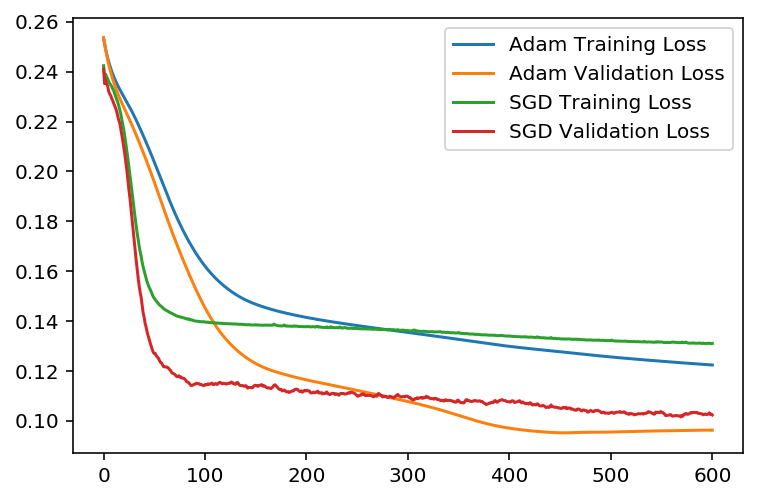

In [9]:
plt.plot(losses_adam['train'], label='Adam Training Loss')
plt.plot(losses_adam['validation'], label='Adam Validation Loss')
plt.plot(losses_sgd['train'], label='SGD Training Loss')
plt.plot(losses_sgd['validation'], label='SGD Validation Loss')
plt.legend()
#_ = plt.ylim()

From the plots, we can observed that using Adam, weights of the neural network are more smoothly adjusted to reduce the training loss. Try increasing the learning rate, and you can see that Adam converges much faster compared to SGD, using an adaptive learning rate.

The benefits of using Adam are not so obvious as the size of the data is very small and increasing training epochs tend to lead to overfitting and early-stopping is required. It is recommended to set the epochs for Adam to around 200 for the above hyperparameters configuration, as the training and validation loss starts diverging. However, we kept the epochs for both networks the same for plotting.

Lastly, in this implementation, Adam is much faster to compute compared to SGD as it is processed as an entire training batch.  

## Test Model

Here, we will compare between the models trained wih Adam and SGD on the test set.

In [10]:
def test_model(network):
    test_predictions = network.run(test_X)
    correct = 0
    total = 0
    for i in range(len(test_predictions)):
        total += 1
        if test_predictions[i] < 0.5 and test_y[i] == 0:
            correct += 1
        elif test_predictions[i] >= 0.5 and test_y[i] == 1:
            correct += 1
    return correct/total
    

In [11]:
print('Adam Test Accuracy: {}'.format(test_model(network_adam)))
print('SGD Test Accuracy: {}'.format(test_model(network_sgd)))

Adam Test Accuracy: 0.8083333333333333
SGD Test Accuracy: 0.85


With an accuracy of 85%, we are placed under the top 100 for the Titanic Machine Learning challenge! Try adding more layers/ dropout to the neural network or swapping out sigmoid for relu or optimize the hyperparameters to improve the accuracy.